In [1]:
from utils import *
from main  import *
from other import *

basicConfig(filename = 'Empirics.log', level = INFO)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
START =  8.5*3600 + 15 * 60
END   = 15.0*3600 - 15 * 60
def filter_time(t, unit='s',
                start=START, end=END):
    """Filter regular trading hour (8:30 a.m. – 3:00 p.m.)
    
    For discarding open and close large trading, we remove first and last 15 
    minutes.
    
    References
    ----------
    .. [1] https://www.cmegroup.com/education/files/eq-trading-hours.pdf
    """
    if unit == 's':
        return t[(t >= start) & (t <= end)]
    if unit == 'm':
        return t[(t >= start/60) & (t <= end/60)]
    else:
        raise NotImplementedError("unit %s is not implemented yet."%unit)


def get_min_value(x, interval=1, start=START, end=END):
    min_ranges = pd.Series(index=np.arange(int(start/60), 
                                           int(end  /60) + interval,
                                           interval),
                           name=x.index.name)
    last = x.groupby(level=0).last()
    out  = pd.merge(min_ranges, last, how='left', 
                    left_index=True, right_index=True)
    out  = out[x.name]
    
    return out.ffill().bfill()


def get_redist(data, min_offset=.001):
    """For the same time points, randomly distribute them."""
    if isinstance(data, pd.DataFrame):
        tmp = data
    else:
        tmp = pd.DataFrame({'t':data})
        
    flag_dup = (tmp.groupby('t')['t'].count() > 1)    
    if flag_dup.sum() == 0:
        tmp['t_redist'] = tmp['t']
        if isinstance(data, pd.DataFrame):
            return tmp
        return tmp['t_redist']
    if len(flag_dup) == 1:
        tmp['t_redist'] = tmp['t']\
                            + np.sort(np.random.uniform(-min_offset * len(tmp),
                                                         min_offset * len(tmp),
                                                        size = len(tmp)))
        if isinstance(data, pd.DataFrame):
            return tmp
        return tmp['t_redist']
    
    flag_dup.name = '1_dup'
    flag_dup = flag_dup.sort_index()
    flag_dup = flag_dup.reset_index()
    flag_dup['st'] = (flag_dup['t'] + flag_dup['t'].shift(1)) / 2
    flag_dup['en'] = (flag_dup['t'] + flag_dup['t'].shift(-1)) / 2
    offset = min(np.nan_to_num(
        flag_dup['st'].iloc[:min(5,len(data))].diff().mean(), nan=1),
                 min_offset)
    flag_dup['st'] = flag_dup['st'].fillna(flag_dup['st'].iloc[1] - offset)
    offset = min(np.nan_to_num(
        flag_dup['en'].iloc[-min(5,len(data)):].diff().mean(), nan=1),
                 min_offset)
    flag_dup['en'] = flag_dup['en'].fillna(flag_dup['en'].iloc[-2] + offset)
    tmp = pd.merge(tmp, flag_dup.reset_index(), how='left', on='t')
    tmp['t_redist'] = (np.random.uniform(size=len(tmp)) * (tmp['en'] - tmp['st'])\
                       + tmp['st'])*tmp['1_dup'] + tmp['t'] * (~tmp['1_dup'])
    
    if isinstance(data, pd.DataFrame):
        return tmp.sort_values('t_redist')
    
    return np.sort(tmp['t_redist'])


def get_VPIN(trade):
    n = 50
    V = trade['Volume'].sum() / n
    if V <= 1:
        return np.nan

    trade['V_i'] = trade['Volume'].cumsum() // V
    VPIN = trade.groupby('V_i')['Signed Volume'].sum().abs().sum() \
            / trade['Volume'].sum()
    
    return VPIN


estimators = [BR_estimation#, Hardiman, AVG_Hardiman_4, AVG_Hardiman_30min,
              #AVG_Hardiman_5min, Exp_estimation, EM_estimation,
             ]
def estimate_Hawkes(points):
    t1 = time()
    ress = {}
    for estimator in estimators:
        ress[estimator.__name__] = estimator(points)
    if VERBOSE:
        print("\t %.3f sec"%(time() - t1))
        
    return ress


def estimate(date, seed=1):
    np.random.seed(seed)
    
    dat = data[date]
    
    out = {}
    trade = dat['trade']
    quote = dat['quote']
    quote['Bid Price'] = quote['Bid Price'].ffill().bfill()
    quote['Ask Price'] = quote['Ask Price'].ffill().bfill()
    quote['Mid Price'] = (quote['Bid Price'] + quote['Ask Price']) / 2
    
    # Summary stats
    out['price(init)'] = trade['Price'][~np.isnan(trade['Price'])].iloc[0]
    out['price(high)'] = np.nanmax(trade['Price'])
    out['price(low)' ] = np.nanmin(trade['Price'])
    out['price(last)'] = trade['Price'][~np.isnan(trade['Price'])].iloc[-1]
    out['price(mean)'] = np.nanmean(trade['Price'])
    out['price(std)' ] = np.nanstd(trade['Price'])
    
    # Liquidity measure
    out['volume'] = np.nansum(trade['Volume'])
    out['dollar_volume'] = np.nansum(trade['Price'] * trade['Volume'])
    out['VPIN'] = get_VPIN(trade[(START <= trade.index) & (trade.index <= END)])
    
    # RV caluclation
    trade['min'] = (trade.index // 60).astype(int)
    price_1min = get_min_value(trade.set_index('min')['Price'], interval=1)
    price_5min = get_min_value(trade.set_index('min')['Price'], interval=5)
    out['RV(1min)'] = RVEstimator(np.log(price_1min))
    out['RV(5min)'] = RVEstimator(np.log(price_5min))
    
    # Hawkes estimation
    mid_mask = (quote['Mid Price'] - quote['Mid Price'].shift(1)).fillna(1) != 0
    
    trade_points = to_0_1(filter_time(get_redist(trade.index)))
    quote_points = to_0_1(filter_time(get_redist(quote.index)))
    mid_points   = to_0_1(filter_time(get_redist(quote[mid_mask].index)))
    
    out['trade']      = estimate_Hawkes(trade_points)
    out['quote']      = estimate_Hawkes(quote_points)
    out['mid_change'] = estimate_Hawkes(mid_points)
    
    del price_1min, price_5min, trade, quote, mid_mask
    del trade_points, quote_points, mid_points
    gc.collect()

    return out


def log_out(i, out):
    pool_out[i] = out

## Estimation

For each day, determine futures product based on volume.
After that, estimate some statistics for that futures data.

    ESH2019        ▼ Maturity of ESH2019
 └─────────────┴─────────┐

        BUFFER ┖──┚    ESM2019  ▲ Maturity of ESM2019
        
                ▲ Choose the next date using volume within this BUFFER

In [3]:
BUFFER  = 14
MIN_NUM = 100
VERBOSE = True

now_quarter = 2000
prev_date   = pd.to_datetime("09/09/1999", format='%m/%d/%Y')
next_date   = pd.to_datetime("09/09/2199", format='%m/%d/%Y')

stop = False
while now_quarter < 2021 or stop:
    t1 = time()
    
    # Load data
    data   = joblib.load('save/E-mini/ES%s.dat'\
                         %get_futures_code(now_quarter))
    dates  = np.array(pd.to_datetime(list(data.keys()), format='%m/%d/%Y')\
                      .sort_values().strftime('%m/%d/%Y').to_list())
    daily_volume = pd.Series([np.nansum(data[date]['trade']['Volume'])
                              for date in dates], 
                             index=pd.to_datetime(dates))

    # Filtering
    bdates    = pd.bdate_range(prev_date, next_date).strftime('%m/%d/%Y')
    liq_dates = np.array([date for date in dates \
                          if len(data[date]['trade']) > MIN_NUM])
    flt_dates = intersect(dates, bdates, liq_dates)
    
    # Estimation
    pool_out = {}
    pool = Pool(cpu_count()-10) 
    try:
        for date in flt_dates:
            if date not in pool_out:
                pool.apply_async(estimate, args=(date,), 
                                 callback=partial(log_out, date))
        pool.close()
        pool.join()
    except KeyboardInterrupt:
        pool.terminate()
    pool_out = dict(sorted(pool_out.items()))
    
    # Choose a next date: A date choosing the next futures product.
    try:
        data2  = joblib.load('save/E-mini/ES%s.dat'\
                             %get_futures_code(now_quarter + .25))
        dates2 = np.array(pd.to_datetime(list(data2.keys()), format='%m/%d/%Y')\
                          .sort_values().strftime('%m/%d/%Y').to_list())
        daily_volume2 = pd.Series([np.nansum(data2[date]['trade']['Volume'])
                                   for date in dates2], 
                                  index=pd.to_datetime(dates2))
    
        next_date = daily_volume.index[-1]  # initialize with the last date.
        for date, vol in daily_volume[-BUFFER:].iteritems():
            if vol < daily_volume2[date]:
                next_date = date
                break
    except:
        stop = True
    
    out_dates = np.array(list(pool_out.keys()))
    for date in out_dates[pd.to_datetime(out_dates) > pd.to_datetime(next_date)]:
        del pool_out[date]
    joblib.dump(pool_out, 'save/emp(BR_only)/%.2f.dat'%now_quarter)

    msg = str(now_quarter) + '\t' + next_date.strftime('%m/%d/%Y')\
          + '  (%5.3f s)'%(time()-t1)
    print(msg); info(msg)
    
    # Go to next step
    prev_date    = next_date + pd.to_timedelta(1, unit='d')
    next_date   += pd.to_timedelta(999, unit='d')
    now_quarter += 0.25

	 0.002 sec
	 0.004 sec
	 0.004 sec
	 0.004 sec
	 0.002 sec
	 0.004 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.004 sec
	 0.002 sec
	 0.003 sec
	 0.003 sec
	 0.004 sec
	 0.004 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.003 sec
	 0.004 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.003 sec
	 0.003 sec
	 0.002 sec
	 0.002 sec
	 0.003 sec
	 0.003 sec
	 0.003 sec
	 0.004 sec
	 0.004 sec
	 0.004 sec
	 0.004 sec
	 0.003 sec
	 0.004 sec
	 0.004 sec
	 0.004 sec
	 0.004 sec
	 0.003 sec
	 0.005 sec
	 0.004 sec
	 0.003 sec
	 0.004 sec
	 0.003 sec
	 0.003 sec
	 0.002 sec
	 0.004 sec
	 0.004 sec
	 0.002 sec
	 0.002 sec
	 0.001 sec
	 0.002 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.004 sec
	 0.003 sec
	 0.003 sec
	 0.001 sec
	 0.003 sec
	 0.003 sec
	 0.004 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.003 sec
	 0.002 sec
	 0.002 sec
	 0.002 sec
	 0.003 sec
	 0.

FileNotFoundError: [Errno 2] No such file or directory: 'save/E-mini/ESZ2019.dat'

In [22]:
outs = {}
for quarter in np.arange(2000, 2020, .25):
    out = joblib.load('save/emp/%.2f.dat'%quarter)
    outs.update(out)
dates = np.array(list(outs.keys()))

In [4]:
outs = {}
outs2 = {}
for quarter in np.arange(2000, 2020, .25):
    out = joblib.load('save/emp/%.2f.dat'%quarter)
    out2 = joblib.load('save/emp(BR_only)/%.2f.dat'%quarter)
    outs.update(out)
    outs2.update(out2)
dates = np.array(list(outs.keys()))

In [5]:
typs = ['trade', 'quote', 'mid_change']
for date in dates:
    for typ in typs:
        outs[date][typ][BR_estimation.__name__] = outs2[date][typ][BR_estimation.__name__]

In [13]:
estimators = [BR_estimation, Hardiman, AVG_Hardiman_4, 
              Exp_estimation, EM_estimation,
             ]
names      = ['Ours', 'H&B', 'H&B(2h)', 'MLE(exp)', 'EM']
typ = 'mid_change'
BRs = []
for date in dates:
    ress = outs[date][typ]
    row  = []
    for estimator in estimators:
        row.append(ress[estimator.__name__]['BR'])
    BRs.append(row)
BRs = pd.DataFrame(BRs, index=pd.to_datetime(dates), columns=names)
BRs['year'] = BRs.index.year
RV_1min = pd.Series(([outs[date]['RV(1min)'] for date in dates]),
                    index=pd.to_datetime(dates))
RV_5min = pd.Series(([outs[date]['RV(5min)'] for date in dates]), 
                    index=pd.to_datetime(dates))
intra_ret = pd.Series(
                [(outs[date]['price(last)'] - outs[date]['price(init)'])\
                 / outs[date]['price(init)'] for date in dates], 
                index=pd.to_datetime(dates))
mid_price = pd.Series(
                [(outs[date]['price(last)'] + outs[date]['price(init)']) / 2\
                 for date in dates], 
                index=pd.to_datetime(dates))
volume = pd.Series([outs[date]['volume'] for date in dates], 
                   index=pd.to_datetime(dates))
dollar_volume = pd.Series(([outs[date]['dollar_volume'] for date in dates]),
                          index=pd.to_datetime(dates))
VPIN = pd.Series(([outs[date]['VPIN'] for date in dates]), 
                 index=pd.to_datetime(dates))
nums = pd.Series(([outs[date][typ][estimators[0].__name__]['N']\
                   for date in dates]), index=pd.to_datetime(dates))

In [14]:
# Generic filter
NUM_MIN = 1300
mask = nums > NUM_MIN

## BR Trends

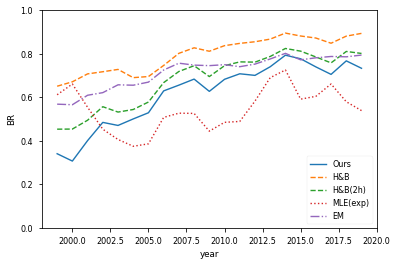

In [15]:
######### Parameters ##########
save = IMG_PATH + "emp/BR_trend.pdf"
lstyles = ['-', '--', '--', ':', '-.']
colors  = ['black']
###############################

BR_year = BRs[mask].groupby('year').mean()

fig  = plt.figure(figsize=(6, 4))
for i in range(len(names)):
    BR_year[names[i]].plot(ls=lstyles[i])
plt.legend()
plt.ylim(0,1)
plt.ylabel('BR')
#plt.title("Yearly averaged branching ratio")

if save != "":
    fig.savefig(save, bbox_inches="tight")

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_scatter(xs, ys, x_names, y_names, row=1, col=None, save=""):
    if col is None:
        col = len(xs)
    figsize  = (10, 1 + row*3)
    fig, axs = plt.subplots(row, col, figsize=figsize)
    for i in range(col):

        x = xs[i]
        y = ys[i]
        mask0 = ~(x.isnull() | y.isnull())
        X = x[mask0].values.reshape(-1,1)
        model = LinearRegression()
        model.fit(X, y[mask0])
        x_new = np.linspace(x[mask0].min(), x[mask0].max(), 100)
        y_new = model.predict(x_new.reshape(-1,1))
        axs[i].scatter(x[mask0], y[mask0], s=1)    

        R2     = r2_score(y[mask0], model.predict(X))
        adj_R2 = 1 - (1-R2) * (len(X)-1) / (len(X)-X.shape[1]-1)
        if model.coef_[0] > 0:
            label = '$Y=%.3f + %.3f X$ \n($R^2=%.3f$, $\\bar{R}^2=%.3f$)'%\
                 (model.intercept_, model.coef_[0], R2, adj_R2)
        else:
            label = '$Y=%.3f  %.3f X$ \n($R^2=%.3f$, $\\bar{R}^2=%.3f$)'%\
                 (model.intercept_, model.coef_[0], R2, adj_R2)
        axs[i].plot(x_new, y_new, c='red', lw=.5, label=label)
        axs[i].set_xlabel(x_names[i])
        axs[i].set_ylabel(y_names[i])
        axs[i].legend(loc='upper right')
        axs[i].set_title("corr = %.3f"%np.corrcoef(x[mask0], y[mask0])[1,0])
        
    plt.show()
    if save != "":
        fig.savefig(save, bbox_inches="tight")

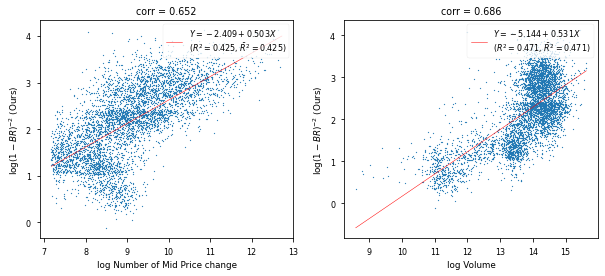

In [11]:
######### Parameters ##########
name = 'Ours'
save =  IMG_PATH + "emp/BR_corr_plot.png"
###############################
xs = [np.log(nums[mask]), np.log(volume[mask])]
ys = [np.log(1/(1-BRs[mask][name])**2)] * 2
x_names = ["log Number of Mid Price change", "log Volume"]
y_names = ["$\log (1-BR)^{-2}$ (%s)"%name] * 2

plot_scatter(xs, ys, x_names, y_names, save=save)

In [12]:
from scipy.optimize import minimize

def R2(x,y):
    X = x.values.reshape(-1,1)
    model = LinearRegression()
    model.fit(X, y)
    return r2_score(y, model.predict(X))

def f(c, name):
    x = np.log(nums/(1 + c*BRs[name])**2 / mid_price**2)
    y = np.log(RV_5min)
    x, y = x[mask], y[mask]
    mask2 = (~x.isnull()) & (~y.isnull())
    return -R2(x[mask2], y[mask2])

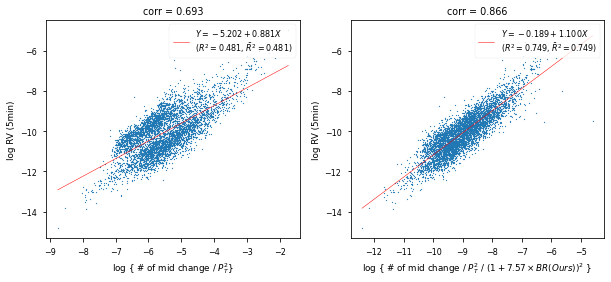

In [13]:
######### Parameters ##########
name = 'Ours'
save = IMG_PATH + "emp/BR_ours_vol_plot.png"
###############################
res = minimize(partial(f, name=name), x0=.4)
c = res.x[0]

xs = [np.log(nums[mask] / mid_price[mask]**2), 
      np.log(nums[mask] / (1+c*BRs[name][mask])**2 / mid_price[mask]**2)]
ys = [np.log(RV_5min[mask])] * 2
x_names = [
    "log $\{$ # of mid change / $P_T^2 \}$", 
    "log $\{$ # of mid change / $P_T^2$ / $(1+%.2f \\times BR(%s))^2$ $\}$"%(c,name)
]
y_names = ["log RV (5min)"] * 2 

plot_scatter(xs, ys, x_names, y_names, save=save)

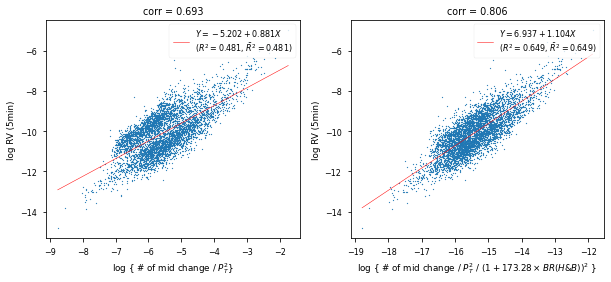

In [14]:
######### Parameters ##########
name = 'H&B'
save = IMG_PATH + "emp/BR_hardiman_vol_plot.png"
###############################
res = minimize(partial(f, name=name), x0=.4)
c = res.x[0]

xs = [np.log(nums[mask] / mid_price[mask]**2), 
      np.log(nums[mask] / (1+c*BRs[name][mask])**2 / mid_price[mask]**2)]
ys = [np.log(RV_5min[mask])] * 2
x_names = [
    "log $\{$ # of mid change / $P_T^2 \}$", 
    "log $\{$ # of mid change / $P_T^2$ / $(1+%.2f \\times BR(%s))^2$ $\}$"%(c,name)
]
y_names = ["log RV (5min)"] * 2 

plot_scatter(xs, ys, x_names, y_names, save=save)

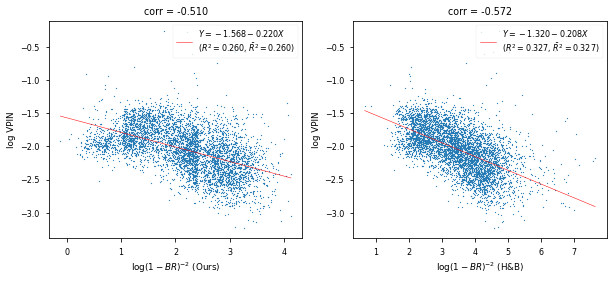

In [15]:
######### Parameters ##########
save = IMG_PATH + "emp/BR_corr_VPIN.png"
###############################
xs = [np.log(1/(1-BRs[mask]['Ours'])**2),
      np.log(1/(1-BRs[mask]['H&B'])**2),
     ]
ys = [np.log(VPIN[mask])] * 2

x_names = ["$\log (1-BR)^{-2}$ (Ours)", "$\log (1-BR)^{-2}$ (H&B)",]
y_names = ["log VPIN"] * 2

plot_scatter(xs, ys, x_names, y_names, save=save)

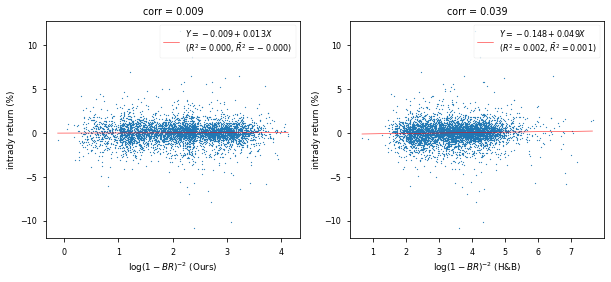

In [16]:
######### Parameters ##########
save = IMG_PATH + "emp/BR_return_plot.png"
###############################
xs = [np.log(1/(1-BRs[mask]['Ours'])**2),
      np.log(1/(1-BRs[mask]['H&B'])**2),
     ]
ys = [intra_ret[mask] * 100] * 2

x_names = ["$\log (1-BR)^{-2}$ (Ours)", "$\log (1-BR)^{-2}$ (H&B)",]
y_names = ["intrady return (%)"] * 2

plot_scatter(xs, ys, x_names, y_names, save=save)

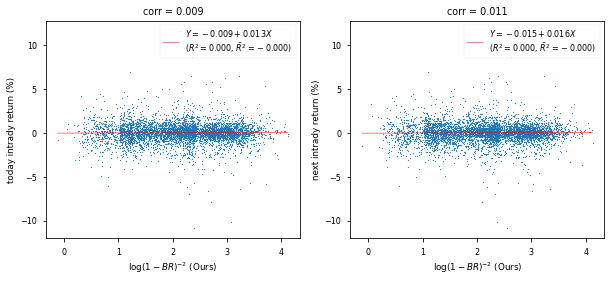

In [35]:
######### Parameters ##########
save = IMG_PATH + "emp/BR_return_plot.png"
###############################
xs = [np.log(1/(1-BRs[mask]['Ours'])**2),
      np.log(1/(1-BRs[mask]['Ours'].iloc[:-1])**2),
     ]
ys = [intra_ret[mask] * 100, intra_ret[mask].shift(-1).iloc[:-1] * 100]

x_names = ["$\log (1-BR)^{-2}$ (Ours)"] * 2
y_names = ["today intrady return (%)", "next intrady return (%)"]

plot_scatter(xs, ys, x_names, y_names, save=save)

In [10]:
def get_z(res, test, ours = 'BR_estimation'):
    return res[ours][test] / res[ours]['SD(%s)'%test]

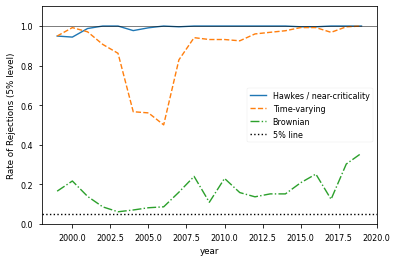

In [20]:
######### Parameters ##########
typ   = 'mid_change'
save  = IMG_PATH + "emp/test_trend_%s.pdf"%typ
tests = ['BR', 'BR - BR_const', 'IV']
names = ['Hawkes / near-criticality', 'Time-varying', 'Brownian']
line_styles = ['-', '--', '-.']
###############################
zs = pd.DataFrame(index=pd.to_datetime(dates))
for i in range(len(tests)):
    zs[names[i]] = [get_z(outs[date][typ], tests[i]) for date in dates]
zs['year'] = zs.index.year

test_ratio = zs[mask].groupby('year').apply(
                lambda x: (np.abs(x) > 1.96).sum() / len(x))
del test_ratio['year']
fig = test_ratio.plot(figsize=(6, 4), style=line_styles).get_figure()
plt.ylabel("Rate of Rejections (5% level)")
#plt.title("Ratio of Test Rejection (%s)"%typ)
plt.axhline(1,   c='black', lw=.5)
plt.axhline(.05, c='black', ls=':', label='5% line')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

if save != "":
    fig.savefig(save, bbox_inches="tight")

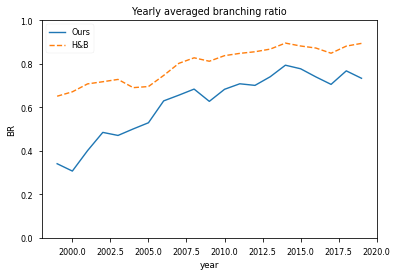

In [21]:
######### Parameters ##########
save = IMG_PATH + "emp/BR_BR_const_trend.pdf"
lstyles = ['-', '--', '--', ':', '-.']
colors  = ['black']
names   = ['Ours', 'H&B']
###############################

BR_year = BRs[mask].groupby('year').mean()

fig  = plt.figure(figsize=(6, 4))
for i in range(2):
    BR_year[names[i]].plot(ls=lstyles[i])
plt.legend()
plt.ylabel("BR")
plt.ylim(0,1)
plt.title("Yearly averaged branching ratio")

if save != "":
    fig.savefig(save, bbox_inches="tight")

<AxesSubplot:xlabel='year'>

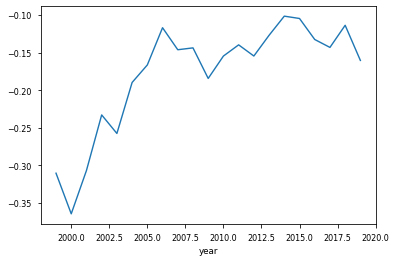

In [64]:
(BR_year['Ours'] - BR_year['H&B']).plot()

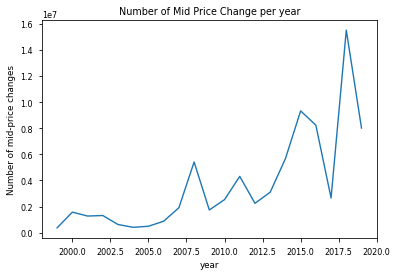

In [22]:
####### Parameters ########
save = IMG_PATH + "emp/year_numbers.pdf"
###########################

tmp = nums.reset_index()
tmp['year'] = tmp['index'].dt.year
fig = tmp.groupby('year')[0].sum().plot(figsize=(6, 4)).get_figure()
plt.title("Number of Mid Price Change per year")
plt.ylabel("Number of mid-price changes")
plt.show()
if save != "":
    fig.savefig(save, bbox_inches="tight")